# Video 3.3 - Donor case study

Some key points

1. This is an EDA - Exploratory Data Analysis exercise.
2. We are starting the spark context in local mode so we can debug. We have one thread running locally and no workers (confirm this)
3. We create a new exception class here that we throw while performing our EDA. More notes on that to follow. 

In [1]:
import pyspark as ps
import os

# Start the context as local to use only one core. 
sc = ps.SparkContext('local')
sc.master

u'local'

In [2]:
cwd = os.getcwd()

In [3]:
rdd = sc.textFile('opendata_projects000')

## Pre-processing tasks just to get started
 - get a count
 - get the headers into a list

In [4]:
rdd.count()

1108217

In [5]:
rdd.first()  # no column headings came through.....

u'"7342bd01a2a7725ce033a179d22e382d","5c43ef5eac0f5857c266baa1ccfa3d3f","9e72d6f2f1e9367b578b6479aa5852b7","360009702803","40.688454000000000","-73.910432000000000","New York City","NY","11207","urban","New York City Dept Of Ed","Kings (Brooklyn)","f","t","f","f","f","f","Mr.","f","f","Other","Applied Learning","","","Supplies","highest poverty","Grades 6-8","","","","","229.00","279.27","0","251","1","f","f","completed","2002-09-13 00:00:00","2002-09-23 00:00:00","2003-01-27 00:00:00","2003-12-31 00:00:00"'

In [6]:
# My headings seem to be missing! So downloaded the headings from the site seprately. 
# Now just checking if I have the same number of columns and if the data looks reasonable.
# extract the first line
first_line = rdd.first()
# split into columns as a list
first_split = first_line.split(',')
# count the number of columns
print "number of columns on first line: ", len(first_split)

#Found the headings on the site
headings = ["_projectid", "_teacher_acctid", "_schoolid", "school_ncesid", "school_latitude",\
            "school_longitude", "school_city", "school_state", "school_zip", "school_metro", "school_district", \
            "school_county", "school_charter", "school_magnet", "school_year_round", "school_nlns", "school_kipp", \
            "school_charter_ready_promise", "teacher_prefix", "teacher_teach_for_america", \
            "teacher_ny_teaching_fellow", "primary_focus_subject", "primary_focus_area" ,"secondary_focus_subject",\
            "secondary_focus_area", "resource_type", "poverty_level", "grade_level", "vendor_shipping_charges",\
            "sales_tax", "payment_processing_charges", "fulfillment_labor_materials",\
            "total_price_excluding_optional_support", "total_price_including_optional_support", "students_reached",\
            "total_donations", "num_donors", "eligible_double_your_impact_match", "eligible_almost_home_match", \
            "funding_status", "date_posted", "date_completed", "date_thank_you_packet_mailed", "date_expiration"]

print "\n number of columns in header: ", len(headings),"\n"

# zip the two together just to see if the data looks like it matches
temp = zip(headings, first_split)
print temp

number of columns on first line:  44

 number of columns in header:  44 

[('_projectid', u'"7342bd01a2a7725ce033a179d22e382d"'), ('_teacher_acctid', u'"5c43ef5eac0f5857c266baa1ccfa3d3f"'), ('_schoolid', u'"9e72d6f2f1e9367b578b6479aa5852b7"'), ('school_ncesid', u'"360009702803"'), ('school_latitude', u'"40.688454000000000"'), ('school_longitude', u'"-73.910432000000000"'), ('school_city', u'"New York City"'), ('school_state', u'"NY"'), ('school_zip', u'"11207"'), ('school_metro', u'"urban"'), ('school_district', u'"New York City Dept Of Ed"'), ('school_county', u'"Kings (Brooklyn)"'), ('school_charter', u'"f"'), ('school_magnet', u'"t"'), ('school_year_round', u'"f"'), ('school_nlns', u'"f"'), ('school_kipp', u'"f"'), ('school_charter_ready_promise', u'"f"'), ('teacher_prefix', u'"Mr."'), ('teacher_teach_for_america', u'"f"'), ('teacher_ny_teaching_fellow', u'"f"'), ('primary_focus_subject', u'"Other"'), ('primary_focus_area', u'"Applied Learning"'), ('secondary_focus_subject', u'""'),


# Data Quality

## Approach for performing some tests on your data
We want to split the row into columns like a tabular format. 
We know there may be some columns that have commas and these will affect the splitting of the data. 

Some investigative steps follow to highlight the rows that have not split correctly. 

In [7]:
# Create the csv rdd
rdd_csv = rdd.map(lambda line: line.split(','))

In [12]:
# now check if any line have more columns than the header

header_columns = len(headings)
rows_in_error = rdd_csv.filter(lambda row: len(row) != header_columns).sum()
print rows_in_error

0


In [13]:
# Odd there are no errors..... but let's go ahead with our new exception class
import pprint

class RowSplitException(Exception):
    pass
    
def throw_exception(row):
    if len(row) != header_columns:
        zip_row = zip(headings,row)
        message = pprint.pformat(zip_row)
        
        raise RowSplitException(message)
    else:
        pass


In [14]:
# Calling this method just over our data basically to test it. 
# This bit of code shows how to just run something over all data just for analysis sake, 
# without creating a new RDD. 
# Note - no output! Not sure why but I don't have commas in my strings.... 

rdd_csv.foreach(throw_exception)

## Debugging: 

Start context single threaded using local - this means all actions and transformations run on that one thread and you can see the stack traces. 
Inspect the stack traces on the driver (your laptop) and the worker logs (coming soon...)

## csv reader and naive splitting

Now if we do have commas in our string fields, how do we work around that? 
Use the csv reader. The next() function generates each of the fields for you. 
Below is a quick example showing this. 


In [32]:
#Source: https://github.com/hopelessoptimism/data-scientists-guide-apache-spark/blob/master/donors_choose_eda.ipynb

import csv

record = '45,3,27.1,Jonathan,Dinu,"Galvanize","San Francisco , CA", 26'

naive = record.split(',')
csv_lib = csv.reader(['45,3,27.1,Jonathan,Dinu,"Galvanize","San Francisco , CA", 26']).next()

print naive
print "Naive splitting creates {0} fields".format(len(naive))
print "\n"

print csv_lib
print "Using the built in CSV library creates {0} fields".format(len(csv_lib))

['45', '3', '27.1', 'Jonathan', 'Dinu', '"Galvanize"', '"San Francisco ', ' CA"', ' 26']
Naive splitting creates 9 fields


['45', '3', '27.1', 'Jonathan', 'Dinu', 'Galvanize', 'San Francisco , CA', ' 26']
Using the built in CSV library creates 8 fields


In [18]:
# So this is how we will create our csv data and our dict data based off this: 

import csv

correct_rdd = rdd.map(lambda line: csv.reader([line]).next())

In [20]:
# Now test the new rdd in csv format and see if ok. 
correct_rdd.foreach(throw_exception)


# Video 3.4 - Data Quality Checks with Accumulators

## Common Questions to ask during EDA: 

How many records are there in total? 

How many unique values does each column contain? 

How many missing or null values are there?

For numeric columns what are its summary statistics? 

What are the values that appear most often in each column? 

How are the values of each column distributed? 

In this project, the problem that we are trying to solve or the goal we want to achieve is to find out the factors that affect the success of a project. So we are trying to determine features that influence the success of a project. 


In [34]:
# For this quality analysis we also need our rdd_dict with dict for each row zipped to the headings. 
rdd_dict = correct_rdd.map(lambda row: dict(zip(headings, row)))
rdd_dict.take(1)

[{'_projectid': '7342bd01a2a7725ce033a179d22e382d',
  '_schoolid': '9e72d6f2f1e9367b578b6479aa5852b7',
  '_teacher_acctid': '5c43ef5eac0f5857c266baa1ccfa3d3f',
  'date_completed': '2002-09-23 00:00:00',
  'date_expiration': '2003-12-31 00:00:00',
  'date_posted': '2002-09-13 00:00:00',
  'date_thank_you_packet_mailed': '2003-01-27 00:00:00',
  'eligible_almost_home_match': 'f',
  'eligible_double_your_impact_match': 'f',
  'fulfillment_labor_materials': '',
  'funding_status': 'completed',
  'grade_level': 'Grades 6-8',
  'num_donors': '1',
  'payment_processing_charges': '',
  'poverty_level': 'highest poverty',
  'primary_focus_area': 'Applied Learning',
  'primary_focus_subject': 'Other',
  'resource_type': 'Supplies',
  'sales_tax': '',
  'school_charter': 'f',
  'school_charter_ready_promise': 'f',
  'school_city': 'New York City',
  'school_county': 'Kings (Brooklyn)',
  'school_district': 'New York City Dept Of Ed',
  'school_kipp': 'f',
  'school_latitude': '40.688454000000000'

In [22]:
# How many records are there in total? 

print rdd_dict.count()


1108217


##### HyperLogLog
rdd_dict.map(lambda row: row['_schoolid']).countApproxDistinct()

rdd_dict.map(lambda row: row['_schoolid']).distinct().count()

With EDA approximate values are often good enough since you are just trying to get a sense of the data. For example, what is the order of magnitude of counts or distinct values?
In addition to getting a sense for the cardinality of a field to understand how many potential values a given column could have, these types of distinct counts can be used to evaluate further methods to use.
If trying to visualize the distribution of a value that has very many distinct values, you might need to bucket your data. Or if you are trying to do a crosstab() you can only have so many distinct values.

rdd_dict.map(lambda row: row['total_price_excluding_optional_support']).countApproxDistinct()

In [23]:
# How many unique values does each column contain? 
# Use rdd.distinct() or rdd.countApproxDistinct(relative accuracy)
# Notice here we are just extracting the column we want to perform analysis on in a separate rdd

rdd_dict.map(lambda row: row['_schoolid']).distinct().count()

71445

In [24]:
rdd_dict.map(lambda row: row['_schoolid']).countApproxDistinct()

71085L

## Missing or null values and Accumulators!!

To get more info on this, go to https://spark.apache.org/docs/1.4.0/api/java/org/apache/spark/sql/DataFrameNaFunctions.html

This site lists all the functions that are available like dropna(column name), fillna(), replace(). These are attached to the dataframe structure. 
There is also column.isNull(). An example is illustrated below - research this when required. 

**Accumulators** are used to find how many null values there are in columns.

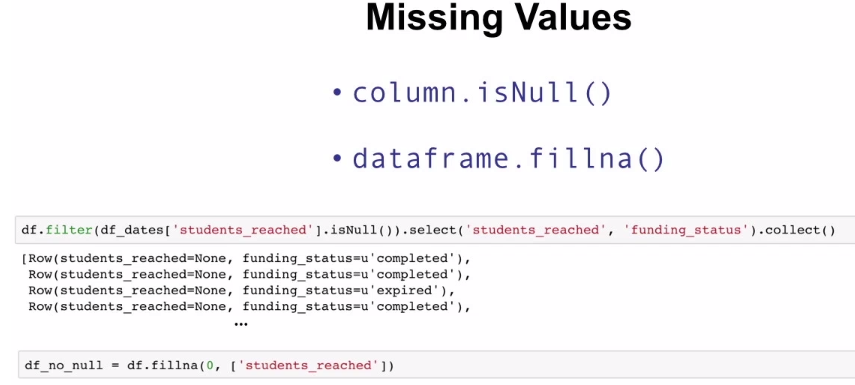

In [35]:
from IPython.display import display, Image
display(Image(filename='Missing Values.png'))

In [36]:
# THIS IS WORTH UNDERSTANDING IN MORE DETAIL - COUNTER OF NULL VALUES FOR EACH COLUMN!!
# An accumulator and Counter are used below to perform a count of the number of nulls in our data. 
# Accumulators are a general concept and can count anything using an int or float, but you can also
# create a custom accumulator that uses the pyuthon Counter() class. This is shown below.
# SOURCE: https://github.com/hopelessoptimism/data-scientists-guide-apache-spark/blob/master/donors_choose_eda.ipynb
# This is how to create a general accumulator. We will be using a custom one. 
accum = sc.accumulator(0)

# define the custom accumulator
from collections import Counter
class CounterAccumulatorParam(ps.accumulators.AccumulatorParam):
    def zero(self, initialValue):
        return Counter()

    def addInPlace(self, v1, v2):
        v1 += v2
        return v1

# now create the accum using the custom function.  
accum = sc.accumulator(Counter(), CounterAccumulatorParam())

# We create a closure below count_null. As this def has its own scope space, we need to make accum global. 
def count_null(record):
    global accum 
    
    c = Counter()
    
    for key, value in record.items(): # iterating through the records in the dict (key.value)
            # since columns are initially strings
            # empty string signals missing value
            if value == '':
                c[key] += 1
                
    accum.add(c)

In [43]:
rdd_dict.foreach(count_null)

In [44]:
accum.value

Counter({'date_completed': 352905,
         'date_expiration': 210,
         'date_thank_you_packet_mailed': 419299,
         'fulfillment_labor_materials': 35082,
         'grade_level': 63,
         'payment_processing_charges': 35082,
         'primary_focus_area': 45,
         'primary_focus_subject': 45,
         'resource_type': 52,
         'sales_tax': 35082,
         'school_city': 9364,
         'school_county': 16,
         'school_district': 353,
         'school_metro': 130456,
         'school_ncesid': 65001,
         'school_zip': 4,
         'secondary_focus_area': 344740,
         'secondary_focus_subject': 344740,
         'students_reached': 155,
         'teacher_prefix': 56,
         'vendor_shipping_charges': 35082})

Looking at the data above you can get a feel for fields that are not so important. 
Some of the dates are not populated at all, also school_metro, secondary_focus..., vendor_shipping charges, etc
Others are pretty well filled in. school_zip only has 4 missing values and the id fields are not in this list so that is good. 

# Video 3.5 describing and visualizing data. 

But before this can happen successfully, there are some more data defining activities described here: 
https://github.com/hopelessoptimism/data-scientists-guide-apache-spark/blob/master/donors_choose_eda.ipynb
Saved locally. 

Note there is a lot of detail in this section of the notebook that will take some time and understanding to got through. Also he has *not explained this section in great detail*. 


### TBD - document this section of the video but also run through the exercises.

### See section "Type Conversion"


### Frequently Occurring Values

We can use the dataframe api to get the frequently occurring values for each column, or just the ones we are interested in. 
